In [1]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from nltk.stem.porter import PorterStemmer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk import bigrams
from nltk.tokenize import word_tokenize
import re
import pandas as pd
import os
import json

# Load Spacy English Model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Etudiant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Text functions

In [2]:
#Segmentation in sentences and tokens and vocabulary
def sentence_segmentation(spacy_text):
    """
    Segments the input text into a list of sentences
    """
    list_of_sentences = []
    for s in spacy_text.sents:
        list_of_sentences.append(s)
    return list_of_sentences

def tokens_segmentation(spacy_text):
    """
    Segments the input text into a list of tokens
    """
    list_of_tokens = []
    for tok in spacy_text:
        list_of_tokens.append(str(tok))
    return list_of_tokens


def lowercase_and_punctuation_remover(spacy_list):
    """
    remove any punctuation and lowercase every item in spacy_list, return the cleaned list
    """
    translator = str.maketrans('', '', string.punctuation) #with string.punctuation being the list of punctuation signs
    return [tok.translate(translator) for tok in [str(tok).lower() for tok in spacy_list]]


def remove_stopwords(spacy_list):
    """
    remove stopwords from the spacy list
    """
    stopwords_list = stopwords.words('english')
    spacy_list_clean = []
    for token in spacy_list:
        if token not in stopwords_list :
            spacy_list_clean.append(token)
    return spacy_list_clean

def remove_empty_spaces(token_list):
    """ 
    Strip each token in the list and remove it if it's empty after stripping
    """
    return [token.strip() for token in token_list if token.strip()]

def stemming(tokens_list):
    """
    Convert every token of the list into its stem
    """
    # create a stemmer instance
    porter = PorterStemmer()
    # apply the stemmer and collect the stems
    porterlemmas = []
    for word in tokens_list:
        porterlemmas.append(porter.stem(word))
    return porterlemmas

def text_data_tok_sent(df):
    """
    Applies the preprocessing functions to the texts abstracts in the dataframe and load the outputs in two new columns of the dataframe : 
    one for the sentences of the text and one for the tokens.
    """
    
    df['sentences'] = df['text'].apply(lambda x: lowercase_and_punctuation_remover(sentence_segmentation(nlp(x))))
                                         
    df['tokens'] = df['sentences'].apply(lambda x: stemming(remove_empty_spaces(remove_stopwords(tokens_segmentation(nlp(' '.join(x)))))))
                                         
    return df 

#Vocabulary: 50 most frequent words and word cloud for each category (Text)
def frequency_and_wordcloud(df):
    """
    Computes the frequency of the word, displays the 50 most frequent words for a category along with its wordcloud
    """
    categories = df['category'].unique()
    results = {}
    
    for category in categories:
        print(f"50 most frequent words and wordcloud for {category}:")
        tokens_list = [item for sublist in df[df['category'] == category]['tokens'] for item in sublist]
        frequency_dist=nltk.FreqDist(tokens_list)
        frequency_dist.plot(50)
        #Create and generate a word cloud image:
        wordcloud = WordCloud().generate(" ".join(tokens_list))
        # Display the generated image:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    
def data_analysis(df): 
    """
    calls the function to update the dataframe with the two columns for sentences and tokens
    """
    df = text_data_tok_sent(df)
    frequency_and_wordcloud(df)
    return df
    


In [3]:
#Sentences: Min/max/avg number of sentences per category together with the corresponding histograms and box plots
def sentences(df):
    """
    Sentences: display min/max/avg number of sentences per category together with the corresponding histograms and box plots
    """
    
    # sentence segmentation and count
    df['sentence_count'] = df['sentences'].apply(lambda x: len(x))

    # min, max, and mean sentence counts by category
    stats_df = df.groupby('category')['sentence_count'].agg(['min', 'max', 'mean'])

    # print statistics
    print(stats_df)
    
    # visualization
    categories = df['category'].unique()
    fig, ax = plt.subplots(1, len(categories)+1, figsize=(12, 6))
    counter = 0 #to keep track of the number of a categorie for subplot index
    for category in categories:
        sns.histplot(df[df["category"] == category], x = 'sentence_count', ax=ax[counter])

        # set titles for each subplot for clarity
        ax[counter].set_title(f'Sentences length frequency for {category}')
        ax[counter].axvline(stats_df.loc[category, 'mean'], color='r', linestyle='--', linewidth=2, label=f'Mean: {stats_df.loc[category, "mean"]:.2f}')
        counter += 1
    
    sns.boxplot(data=df, x='category', y='sentence_count', ax=ax[counter])
    ax[counter].set_title('Boxplot')
    plt.show()

In [4]:
#Tokens: Total number of bi-gram occurrences per category. Min/max/avg number of bi-gram occurrences per sentence per category.

def generate_bigrams(sentences_list):
    """
    Generates bigrams from the list of sentences
    """
    all_bigrams = []
    for sent in sentences_list:
        # bigrams from the list of sentences
        tokens = word_tokenize(sent)
        all_bigrams.append(list(bigrams(tokens))) #list of list of bigrams (one per sentence)
    return all_bigrams


def get_bigrams_list(df):
    """
    apply the previous function (generate_bigrams) to create a new column in the dataframe to store the bigrams
    """
    df['bigrams'] = df['sentences'].apply(generate_bigrams)
    return df
    
def total_bigram_occ(df):
    """
    display total number of bi-gram occurrences per category and min/max/avg number of bi-gram occurrences per sentence per category
    """
    pers_bigrams = {}
    sent_bigrams = {}
    all_bigrams = {}
    
    categories = df['category'].unique()
    for category in categories:
        pers_bigrams[category] = [x for x in df[df["category"] == category]['bigrams']]
        sent_bigrams[category] = sum(pers_bigrams[category], [])
        all_bigrams[category] = sum(sent_bigrams[category], [])
        print(f"For the category {category}:")
        print(f"  there are {len(all_bigrams[category])} bigrams in total and {len(set(all_bigrams[category]))} unique bigrams")
        print(f"  the minimum number of bigrams in a sentence is {min([len(s) for s in sent_bigrams[category]])}")
        print(f"  the maximum number of bigrams in a sentence is {max([len(s) for s in sent_bigrams[category]])}")
        print(f"  the average number of bigrams in a sentence is {sum([len(s) for s in sent_bigrams[category]])/len(sent_bigrams[category])}")


## Graph functions

In [5]:
def retrieve_json(path):
    """
    Retrieves and loads json file from a provided path
    """
    print(path)
    json_string = open(path)
    
    graph = json.load(json_string)
    return graph

def extract_after_last_slash(text): 
    """
    Preprocessing step for facts: as facts are given as URI, we only keep the actual fact as a word which is at the end of the URI (ex : sameAs)
    """
    # for facts, regex to find the part after the last slash (to keep only the fact and not the url)
    match = re.search(r'[^/]+$', text)
    if match:
        return match.group(0)
    return None

#RDFproperties: 50 most frequent properties and property cloud for each category
def most_freq_properties_and_cloud(json_str):
    """
    displays 50 most frequent properties and property cloud for each category
    """
    properties_per_category = {}
    properties_per_category_clean = {}

    for category, items in json_str.items():
        properties_per_category[category] = []
        properties_per_category_clean[category] = []

        for item in items:
            # extract all 'p' values from the bindings
            bindings = item['results']['bindings']
            for binding in bindings:
                property_value = binding['p']['value']
                #append property
                properties_per_category[category].append(property_value)
                properties_per_category_clean[category] = [extract_after_last_slash(prop) for prop in properties_per_category[category]]

        print(f"50 most frequent properties and wordcloud of properties for {category}:")
        frequency_dist_dist=nltk.FreqDist(properties_per_category_clean[category])
        frequency_dist_dist.plot(50)
        #Create and generate a word cloud image:
        wordcloud_prop = WordCloud().generate(" ".join(properties_per_category_clean[category]))
        # Display the generated image:
        plt.imshow(wordcloud_prop, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        

#Facts: Min/max/avg number of facts per category together. Histograms and box plots for number of facts per graph for each category
def facts_graphs(json_str):
    """
    displays min/max/avg number of facts per category together. Histograms and box plots for number of facts per graph for each category
    """
    facts = {'category' : [], 'number_facts' : []}

    for category, items in json_str.items():
        for item in items:
            bindings = item['results']['bindings']
            facts['category'].append(category)
            facts['number_facts'].append(len(bindings))
            
    df_graphs = pd.DataFrame(facts)
    
    # min, max, and mean number of facts per person by category
    stats_df_graphs = df_graphs.groupby('category')['number_facts'].agg(['min', 'max', 'mean'])

    # print statistics
    print(stats_df_graphs)
    
    # visualization
    categories = df_graphs['category'].unique()
    fig, ax = plt.subplots(1, len(categories)+1, figsize=(12, 6))
    counter = 0 #to keep track of the number of a categorie for subplot index
    for category in categories:
        sns.histplot(df_graphs[df_graphs["category"] == category], x = 'number_facts', ax=ax[counter])

        # set titles for each subplot for clarity
        ax[counter].set_title(f'Number of facts by person for {category}')
        ax[counter].axvline(stats_df_graphs.loc[category, 'mean'], color='r', linestyle='--', linewidth=2, label=f'Mean: {stats_df_graphs.loc[category, "mean"]:.2f}')
        counter += 1
    
    sns.boxplot(data=df_graphs, x='category', y='number_facts', ax=ax[counter])
    ax[counter].set_title('Boxplot')
    plt.show()
                

## Text analysis display

50 most frequent words and wordcloud for Sculptors:


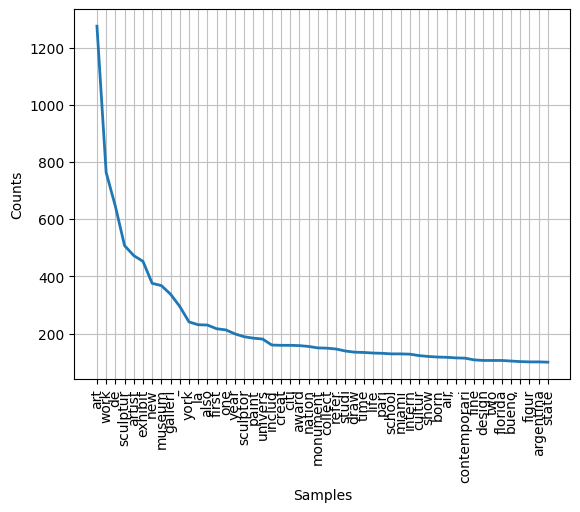

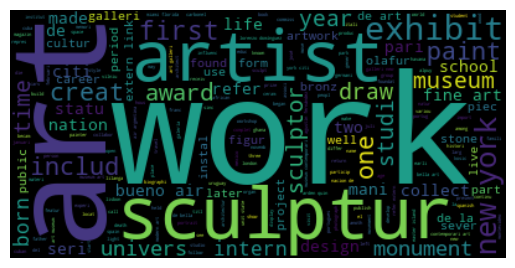

50 most frequent words and wordcloud for Journalists:


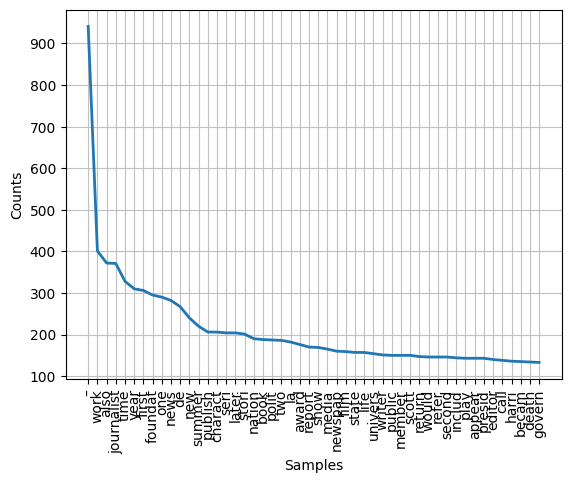

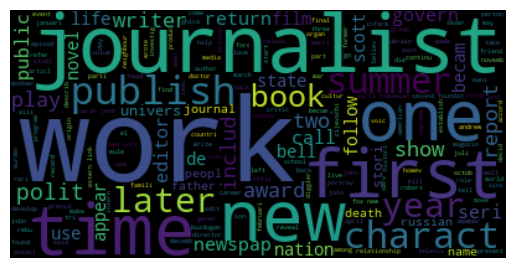

             min  max       mean
category                        
Journalists    3  492  52.876923
Sculptors      1  363  35.546154


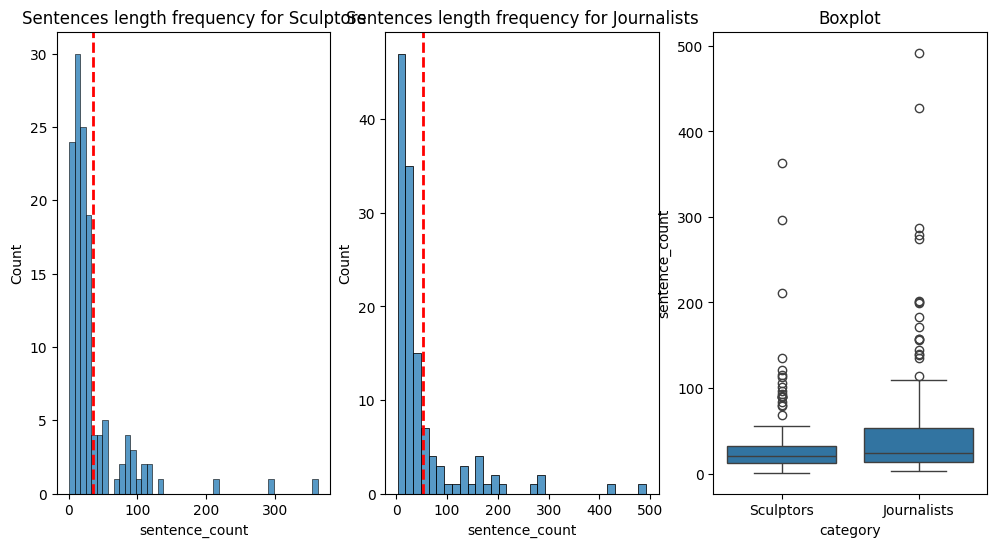

For the category Sculptors:
  there are 87847 bigrams in total and 52457 unique bigrams
  the minimum number of bigrams in a sentence is 0
  the maximum number of bigrams in a sentence is 362
  the average number of bigrams in a sentence is 19.01038736204285
For the category Journalists:
  there are 138083 bigrams in total and 81656 unique bigrams
  the minimum number of bigrams in a sentence is 0
  the maximum number of bigrams in a sentence is 569
  the average number of bigrams in a sentence is 20.087721850450976


In [6]:
#TEXT Data analysis
#Approximately 3 minutes to run
df = pd.read_csv('biographies_dataframe.csv')
df.head()

df = data_analysis(df)
sentences(df)
df = get_bigrams_list(df)
total_bigram_occ(df)

## Graphs analysis display

Biographies\knowledge_graph.json
50 most frequent properties and wordcloud of properties for Journalists:


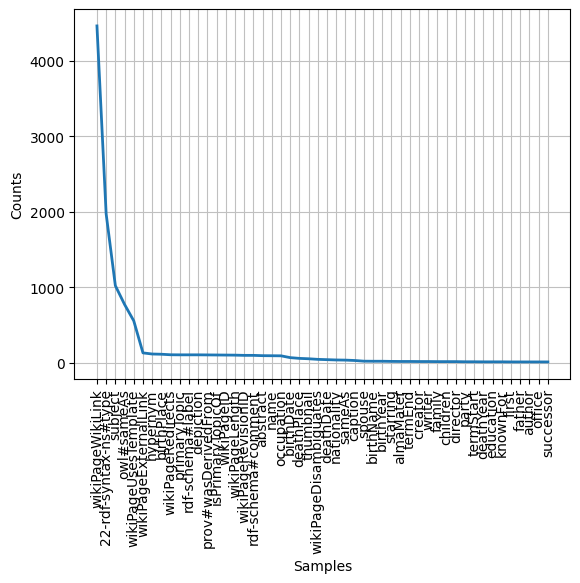

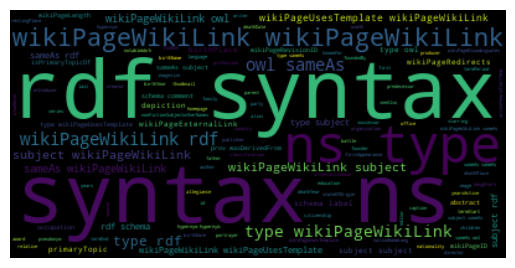

50 most frequent properties and wordcloud of properties for Sculptors:


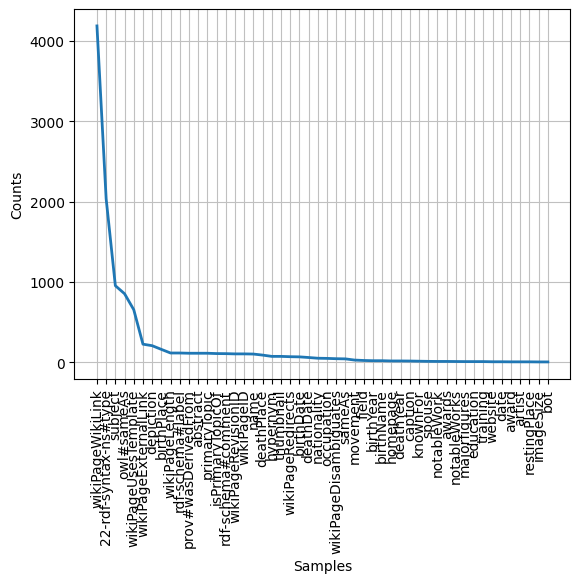

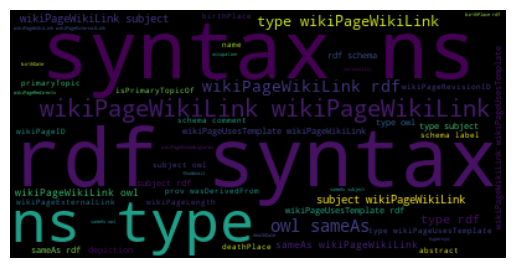

             min  max       mean
category                        
Journalists   11  100  87.423077
Sculptors     36  100  87.346154


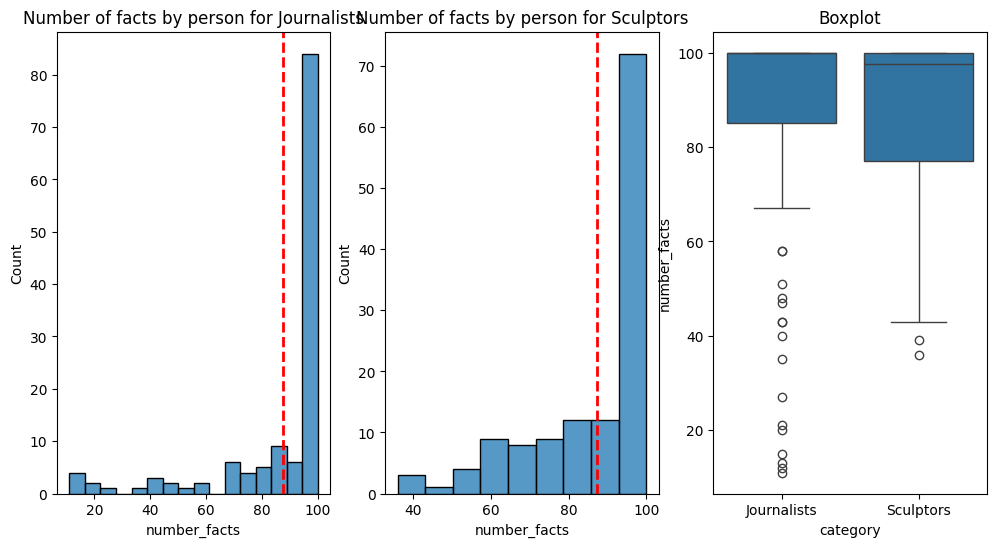

In [7]:
#GRAPH data analysis
#Approximately 10 minutes to run
knowledge_graph = retrieve_json('Biographies\\knowledge_graph.json')
most_freq_properties_and_cloud(knowledge_graph)
facts_graphs(knowledge_graph)